# UQ on ISBI2015 Cephalometric Landmark Detection Challenge

## Load Libraries

In [1]:
import sys

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from monai.transforms import RandFlipd, Compose, RandAffined, ScaleIntensityd, LoadImage

from landmarker.transforms.images import UseOnlyFirstChannel

In [ ]:
sys.path.append('../training')

from datasets.isbi2015 import get_isbi2015_dataset

## Load data

In [ ]:
path_dir = "../data"

In [4]:
inference_transform = Compose([
    UseOnlyFirstChannel(keys=["image"]),
    ScaleIntensityd(keys=["image"], dtype=None)
])

In [5]:
train_dataset, val_dataset, test_dataset = get_isbi2015_dataset(path_dir,
                                                                val_fold=2,
                                                                test_fold=3,
                                                                kind="mask",
                                                                dim_img=(512, 512),
                                                                train_transform=inference_transform,
                                                                inference_transform=inference_transform,
                                                                store_imgs=False)

## Model Initialization

In [ ]:
from models.shr import StaticHeatmapRegression
from landmarker.losses import NLLLoss
from landmarker.models.utils import SoftmaxND
from monai.transforms import RandAffine
from glob import glob

from segmentation_models_pytorch import Unet
from copy import deepcopy

nb_landmarks = 19
MC_inference_samples = 20
TTA_transforms = Compose([
    RandAffine(
        prob=1,
        rotate_range=(-0.1, 0.1),
        translate_range=(-10, 10),
        scale_range=(-0.1, 0.1),
    )
])

one_hot_decoder_method = "local_soft_argmax"
one_hot_heatmap_model = StaticHeatmapRegression(
    model = Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1,
        classes=19,
        decoder_channels= [256, 128, 64, 32, 32]
    ),
    loss = NLLLoss(),
    final_activation = SoftmaxND(spatial_dims=2),
    decoder_method=one_hot_decoder_method
)

state_dict_one_hot = torch.load("../results/lightning_model_checkpoints/ISBI2015/ISBI2015_shr_unet_NLLLoss_val_fold2_test_fold3.ckpt", map_location="cpu")["state_dict"]
one_hot_heatmap_model.load_state_dict(state_dict_one_hot)

one_hot_heatmap_model_tta = deepcopy(one_hot_heatmap_model)
one_hot_heatmap_model_tta.TTA = True
one_hot_heatmap_model_tta.TTA_transforms = TTA_transforms
one_hot_heatmap_model_tta.MC_inference_samples = MC_inference_samples

one_hot_heatmap_model_ensemble = StaticHeatmapRegression(
    model = Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1,
        classes=19,
        decoder_channels= [256, 128, 64, 32, 32]
    ),
    loss = NLLLoss(),
    final_activation = SoftmaxND(spatial_dims=2),
    ensemble=True,
    decoder_method=one_hot_decoder_method,
    ensemble_ckpts = glob("../results/lightning_model_checkpoints/ISBI2015/ensemble/shr_unet/*.ckpt")
)

one_hot_heatmap_model_ts = deepcopy(one_hot_heatmap_model)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'final_activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['final_activation'])`.
/tmp/ipykernel_1461/814995746.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible

In [7]:
import lightning as L

trainer = L.Trainer(accelerator="gpu")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=5, shuffle=False)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Producing prediction regions
Approaches to conformalize the landmark prediction task:
* Ellipsoidal prediction regions using the mahalanobis distance as nonconformity measure and use covariance matrix (prefarbly adaptive)
* Statistical correction
    1) Normalized absolute error, variance defined by MC-dropout, TTA, ensemble
    2) Absolute error
* Maximum non-conformity measure
* Regression-as-classification approach (more a density based approach) (we extend it to the multi-ouput problem)

In [9]:
# Ensemble models for increased predictive performace
val_results_one_hot_ensemble = trainer.predict(one_hot_heatmap_model_ensemble, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
# Ensemble models for increased predictive performace
test_results_one_hot_ensemble = trainer.predict(one_hot_heatmap_model_ensemble, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Ellipsoidal Prediction Regions

In [11]:
sys.path.append('../..')

from src.uncertainty import *

In [12]:
one_hot_results = {}
confidence_level = 0.90

In [13]:
print("="*100)
print("One-hot-encoded model")
print("="*100)

print(f"Fit and evaluate Ellipsoid CP regions with Ensemble (heatmap derived cov) for {100*confidence_level}%")
cp_mahalanobis_one_hot_ensemble_heatmap_cov = ConformalRegressorMahalanobis(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
cp_mahalanobis_one_hot_ensemble_heatmap_cov.fit(pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
                                  pred_cov=np.concatenate([result["covariance_orig_size"] for result in val_results_one_hot_ensemble]),
                                  target=val_dataset.landmarks)
one_hot_results["one_hot_ensemble_elliposoid_heatmap_cov"] = cp_mahalanobis_one_hot_ensemble_heatmap_cov.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level)
print("-"*50)

print(f"Fit and evaluate Bonferroni CP regions with Ensemble (heatmap derived sigma) for {100 * confidence_level}%")
cp_bonferroni_one_hot_ensemble_heatmap_sigma = ConformalRegressorBonferroni(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
cp_bonferroni_one_hot_ensemble_heatmap_sigma.fit(
    pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1], [0, 1]] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_bonferroni_heatmap_sigma"] = cp_bonferroni_one_hot_ensemble_heatmap_sigma.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1], [0, 1]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-" * 50)

print(f"Fit and evaluate Max Nonconformity CP regions with Ensemble (heatmap derived sigma) for {100*confidence_level}%")
cp_max_one_hot_ensemble_heatmap_sigma = ConformalRegressorMaxNonconformity(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
cp_max_one_hot_ensemble_heatmap_sigma.fit(pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
                                  sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in val_results_one_hot_ensemble]),
                                  target=val_dataset.landmarks)
one_hot_results["one_hot_ensemble_max_score_heatmap_sigma"] = cp_max_one_hot_ensemble_heatmap_sigma.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level)
print("-"*50)

print(f"Fit and evaluate MR2CCP regions with Ensemble for {100*confidence_level}%")
mr2ccp_one_hot_ensemble = MR2CCP(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
mr2ccp_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_mr2ccp"] = mr2ccp_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

print(f"Fit and evaluate MR2C2R regions with Ensemble for {100*confidence_level}%")
mr2c2r_one_hot_ensemble = MR2C2R(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
mr2c2r_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_mr2cr"] = mr2c2r_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

print(f"Fit and evaluate MR2C2R (APS) regions with Ensemble for {100*confidence_level}%")
mr2c2r_aps_one_hot_ensemble = MR2C2R(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks,
                                                        aps=True)
mr2c2r_aps_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks,
    confidence=confidence_level
)
one_hot_results["one_hot_ensemble_mr2c2r_aps"] = mr2c2r_aps_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

One-hot-encoded model
Fit and evaluate Ellipsoid CP regions with Ensemble (heatmap derived cov) for 90.0%
Coverage: 0.89
Efficiency (mean): 10.781715393066406
Efficiency (median): 6.874436378479004
Efficiency (Q1): 4.953955769538879
Efficiency (Q3): 11.83610224723816
Adeptivity: 0.36781800478994153
--------------------------------------------------
Fit and evaluate Bonferroni CP regions with Ensemble (heatmap derived sigma) for 90.0%
Coverage: 0.8926315789473684
Efficiency (mean): 31.736770629882812
Efficiency (median): 8.252487182617188
Efficiency (Q1): 4.778641104698181
Efficiency (Q3): 17.49385404586792
Adeptivity: 0.3926578454657977
--------------------------------------------------
Fit and evaluate Max Nonconformity CP regions with Ensemble (heatmap derived sigma) for 90.0%
Coverage: 0.8868421052631579
Efficiency (mean): 31.626018524169922
Efficiency (median): 8.152961730957031
Efficiency (Q1): 4.624609351158142
Efficiency (Q3): 16.503543853759766
Adeptivity: 0.39574399298929674
-

100%|██████████| 100/100 [05:02<00:00,  3.03s/it]


Coverage: 0.8984210526315789
Efficiency (mean): 8.671537455881113
Efficiency (median): 6.770000479184091
Efficiency (Q1): 5.317500376375392
Efficiency (Q3): 9.922500702319667
Adeptivity: 0.3401952303084253
--------------------------------------------------
Fit and evaluate MR2C2R regions with Ensemble for 90.0%


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


Coverage: 0.8921052631578947
Efficiency (mean): 7.731700547253713
Efficiency (median): 5.72000040486455
Efficiency (Q1): 4.320000305771828
Efficiency (Q3): 9.002500637201592
Adeptivity: 0.3256024671614206
--------------------------------------------------
Fit and evaluate MR2C2R (APS) regions with Ensemble for 90.0%


100%|██████████| 100/100 [05:54<00:00,  3.55s/it]

Coverage: 0.8942105263157895
Efficiency (mean): 8.089326888356162
Efficiency (median): 5.58500039530918
Efficiency (Q1): 4.120000291615725
Efficiency (Q3): 9.240000654011965
Adeptivity: 0.3759010269601517
--------------------------------------------------


In [14]:
print(f"Fit and evalua te Ellipsoid Normal regions with Ensemble (heatmap derived cov) for {100*confidence_level}%")
mutli_normal_one_hot_ensemble_heatmap_cov = MultivariateNormalRegressor(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
mutli_normal_one_hot_ensemble_heatmap_cov.fit(pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
                                  pred_cov=np.concatenate([result["covariance_orig_size"] for result in val_results_one_hot_ensemble]),
                                  target=val_dataset.landmarks)
one_hot_results["one_hot_ensemble_multi_normal_heatmap_cov"] = mutli_normal_one_hot_ensemble_heatmap_cov.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level)
print("-"*50)

print(f"Fit and evaluate contour hugging regions with Ensemble for {100*confidence_level}%")
contour_hugging_one_hot_ensemble = ContourHuggingRegressor(spatial_dims=2, nb_landmarks=val_dataset.nb_landmarks)
contour_hugging_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_contour_hugging"] = contour_hugging_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

Fit and evalua te Ellipsoid Normal regions with Ensemble (heatmap derived cov) for 90.0%
Coverage: 0.6189473684210526
Efficiency (mean): 3.5803580284118652
Efficiency (median): 2.5928359031677246
Efficiency (Q1): 1.970060646533966
Efficiency (Q3): 4.025196313858032
Adeptivity: 0.3958434623272457
--------------------------------------------------
Fit and evaluate contour hugging regions with Ensemble for 90.0%


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]

Coverage: 0.8742105263157894
Efficiency (mean): 6.632589943142314
Efficiency (median): 5.0700003588572145
Efficiency (Q1): 3.520000249147415
Efficiency (Q3): 8.032500568544492
Adeptivity: 0.39552707825177996
--------------------------------------------------


In [14]:
pred_contour_ellipse = (cp_mahalanobis_one_hot_ensemble_heatmap_cov.predict_contour(
                    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
                    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
                    confidence=confidence_level, sample_points=200) - 
                        np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                              ).reshape((len(test_results_one_hot_ensemble), 1, nb_landmarks, 2))
)
in_region_ellipse = cp_mahalanobis_one_hot_ensemble_heatmap_cov.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_contour_bonferroni = (np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                              ).reshape((len(test_results_one_hot_ensemble), 1, nb_landmarks, 2)) -
                           cp_bonferroni_one_hot_ensemble_heatmap_sigma.predict_contour(
                    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
                    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
                    confidence=confidence_level, sample_points=200)
)
in_region_bonferroni = cp_bonferroni_one_hot_ensemble_heatmap_sigma.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_contour_max_nonconformity = (cp_max_one_hot_ensemble_heatmap_sigma.predict_contour(
                    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
                    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
                    confidence=confidence_level, sample_points=200) -
                                  np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                              ).reshape((len(test_results_one_hot_ensemble), 1, nb_landmarks, 2))
)
in_region_max_nonconformity = cp_max_one_hot_ensemble_heatmap_sigma.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_contour_mr2ccp = mr2ccp_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2ccp = mr2ccp_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

pred_contour_mr2c2r = mr2c2r_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2c2r = mr2c2r_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

pred_contour_mr2c2r_aps = mr2c2r_aps_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2c2r_aps = mr2c2r_aps_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

Alert: contour caluculation is a lower bound


100%|██████████| 100/100 [05:31<00:00,  3.32s/it]


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_single_landmark_sample(sample_idx, landmark_idx, save=False):
    blue = np.array([75/255, 157/255, 220/255])
    red = np.array([238/255, 111/255, 117/255])
    yellow = np.array([255/255, 208/255, 52/255])
    # Error calculation
    error = (np.concatenate(
        [result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
    ) - test_dataset.landmarks.numpy())[:, landmark_idx]
    pred_landmarks = np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                  ).reshape((len(test_results_one_hot_ensemble), nb_landmarks, 2))
    pred_landmark = pred_landmarks[sample_idx, landmark_idx]
    
    # Create the figure and define the GridSpec layout
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 3*2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
    axs = [
        fig.add_subplot(gs[0, :2]),
        fig.add_subplot(gs[0, 2:4]),
        fig.add_subplot(gs[0, 4:6])
    ]
    axs.append(fig.add_subplot(gs[1, 0:2]))
    axs.append(fig.add_subplot(gs[1, 2:4]))
    axs.append(fig.add_subplot(gs[1, 4:6]))
    
    # Define titles for each subplot
    titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]
    
    
    lim_min = np.inf
    lim_max = -np.inf
    
    # Iterate through each subplot and populate it
    for idx, ax in enumerate(axs):
        ax.set_title(titles[idx], fontsize=12)
        ax.set_aspect('equal')
        # Select the appropriate contour and correctness data
        if idx == 2:
            contour = pred_contour_ellipse[sample_idx,:, landmark_idx]
            correct = in_region_ellipse[sample_idx, landmark_idx]
        elif idx == 0:
            contour = pred_contour_bonferroni[sample_idx,:, landmark_idx]
            correct = in_region_bonferroni[sample_idx, landmark_idx]
        elif idx == 1:
            contour = pred_contour_max_nonconformity[sample_idx, :, landmark_idx]
            correct = in_region_max_nonconformity[sample_idx, landmark_idx]
        elif idx == 3:
            contour = pred_contour_mr2ccp[sample_idx][landmark_idx]
            correct = in_region_mr2ccp[sample_idx, landmark_idx]
        elif idx == 4:
            contour = pred_contour_mr2c2r[sample_idx][landmark_idx]
            correct = in_region_mr2c2r[sample_idx, landmark_idx]
        elif idx == 5:
            contour = pred_contour_mr2c2r_aps[sample_idx][landmark_idx]
            correct = in_region_mr2c2r_aps[sample_idx, landmark_idx]
        
        # Plot contour
        if idx < 3:
            # For the first three subplots, contour is 2D
            lim_max = np.maximum(contour.max(), lim_max)
            lim_min = np.minimum(contour.min(), lim_min)
            ax.plot(contour[:, 1], contour[:, 0],
                    color="black", linewidth=1.0, label="Prediction Region")
        else:
            # For the last two subplots, contour might have multiple parts
            for part_contour in contour:
                part_contour = np.vstack([part_contour, part_contour[0:1]])
                part_contour = np.flip(pred_landmark, axis=-1) - part_contour[:,0]
                lim_max = np.maximum(part_contour.max(), lim_max)
                lim_min = np.minimum(part_contour.min(), lim_min)
                ax.plot(
                    part_contour[:,0],
                    part_contour[:,1],
                    color="black",
                    linewidth=1.0,
                    label="Prediction Region"
                )

        # Determine color based on correctness
        color = blue if correct else red

        # Scatter the error point
        ax.scatter(error[sample_idx, 1], error[sample_idx, 0],
                   s=100, c=color, edgecolor='white', linewidth=1.5, label="True Point")

        # Scatter the origin point
        ax.scatter(0, 0, s=100, c="black", edgecolor='white', linewidth=1.5, label="Prediction Point")

        # Add central axis lines
        ax.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax.axvline(0, color="gray", linestyle="--", linewidth=1)

        # Add gridlines
        ax.grid(True, linestyle="--", alpha=0.7)


        # Set equal aspect ratio
        ax.set_aspect('equal', adjustable='box')

        # Add legend only once to avoid repetition
        if idx == 0:
            ax.legend(fontsize=10, loc="upper right")


    for ax in axs:
        ax.set_xlim(lim_min-1, lim_max+1)
        ax.set_ylim(lim_min-1, lim_max+1)
    axs[0].set_ylabel("y")
    axs[3].set_ylabel("y")
    axs[3].set_xlabel("x")
    axs[4].set_xlabel("x")
    axs[5].set_xlabel("x")

    # Optional: Add a main title
    #plt.suptitle(f'Landmark {landmark_idx} Error Analysis for Sample {sample_idx}', fontsize=20, fontweight="bold")
    if save:
        plt.savefig(f"landmark_{landmark_idx}_sample_{sample_idx}_error_analysis.pdf", bbox_inches="tight")

    # Display the plot
    plt.show()

In [ ]:
plot_single_landmark_sample(sample_idx=18, landmark_idx=1, save=True)

/tmp/ipykernel_1461/3182436788.py:94: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(error[sample_idx, 1], error[sample_idx, 0],


In [30]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_single_landmark_all_samples(landmark_idx, save=False):
    blue = np.array([75/255, 157/255, 220/255])
    red = np.array([238/255, 111/255, 117/255])
    # Error calculation
    error = (test_dataset.landmarks - np.concatenate(
        [result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
    ))[:, landmark_idx]
    pred_landmarks = np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                  ).reshape((len(test_results_one_hot_ensemble), nb_landmarks, 2))
    
    # Create the figure and define the GridSpec layout
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 3*2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
    axs = [
        fig.add_subplot(gs[0, :2]),
        fig.add_subplot(gs[0, 2:4]),
        fig.add_subplot(gs[0, 4:6])
    ]
    axs.append(fig.add_subplot(gs[1, 0:2]))
    axs.append(fig.add_subplot(gs[1, 2:4]))
    axs.append(fig.add_subplot(gs[1, 4:6]))
    
    # Define titles for each subplot
    titles = titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]
    
    
    lim_min = np.inf
    lim_max = -np.inf
    
    # Iterate through each subplot and populate it
    for idx, ax in enumerate(axs):
        ax.set_title(titles[idx], fontsize=12)
        ax.set_aspect('equal')
        # Select the appropriate contour and correctness data
        if idx == 2:
            contour = pred_contour_ellipse[:,:, landmark_idx]
            correct = in_region_ellipse[:, landmark_idx]
        elif idx == 0:
            contour = pred_contour_bonferroni[:,:, landmark_idx]
            correct = in_region_bonferroni[:, landmark_idx]
        elif idx == 1:
            contour = pred_contour_max_nonconformity[:, :, landmark_idx]
            correct = in_region_max_nonconformity[:, landmark_idx]
        elif idx == 3:
            pred_contour = pred_contour_mr2ccp
            correct = in_region_mr2ccp[:, landmark_idx]
        elif idx == 4:
            pred_contour = pred_contour_mr2c2r
            correct = in_region_mr2c2r[:, landmark_idx]
        elif idx == 5:
            pred_contour = pred_contour_mr2c2r_aps
            correct = in_region_mr2c2r_aps[:, landmark_idx]
        
        # Plot contour
        if idx < 3:
            # For the first three subplots, contour is 2D
            lim_max = np.maximum(contour.max(), lim_max)
            lim_min = np.minimum(contour.min(), lim_min)
            for i in range(len(error)):
            #for i in [random.randrange(0, 100, 2) for _ in range(1)]:
                ax.plot(contour[i,:,1], contour[i,:,0], color="black", linewidth=0.2)
                color = blue if correct[i] else red
                ax.scatter(error[i, 1], error[i, 0], s=1, c=color)
        else:
            for i, contour in enumerate(pred_contour):
                contour = contour[landmark_idx]
                for part_contour in contour:
                    part_contour = np.vstack([part_contour, part_contour[0:1]])
                    part_contour = part_contour[:,0] - np.flip(pred_landmarks[i, landmark_idx], axis=-1)
                    lim_max = np.maximum(part_contour.max(), lim_max)
                    lim_min = np.minimum(part_contour.min(), lim_min)
                    ax.plot(part_contour[:,0],
                                part_contour[:,1],
                                color="black",
                                linewidth=0.2)
                    color = blue if correct[i] else red
                    ax.scatter(error[i, 1], error[i, 0], s=1, c=color)
    
        # Scatter the origin point
        #ax.scatter(0, 0, s=1, c="black", edgecolor='white', linewidth=1.5, label="Origin")
        
        # Add central axis lines
        ax.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax.axvline(0, color="gray", linestyle="--", linewidth=1)
        
        # Add gridlines
        ax.grid(True, linestyle="--", alpha=0.7)
        
        
        # Set equal aspect ratio
        ax.set_aspect('equal', adjustable='box')

        # Legend definition
        correct_point = mlines.Line2D([], [], color=blue, marker='o', linestyle='None', markersize=1, label="Correct")
        incorrect_point = mlines.Line2D([], [], color=red, marker='o', linestyle='None', markersize=1, label="Incorrect")
        contour_line = mlines.Line2D([], [], color="black", linewidth=0.5, label="Contour Line")
        origin_marker = mlines.Line2D([], [], color="gray", linestyle="--", linewidth=1, label="Origin Axis")
        
        # Add legend only once to avoid repetition
        if idx == 0:
            ax.legend(handles=[correct_point, incorrect_point, contour_line, origin_marker], fontsize=10)
    lim_max = np.minimum(lim_max, 100)
    lim_min = np.maximum(lim_min, -100)
    for ax in axs:
        ax.set_xlim(lim_min-1, lim_max+1)
        ax.set_ylim(lim_min-1, lim_max+1)
    if save:
        plt.savefig(f"landmark_{landmark_idx}_all_points_error_analysis.pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_1555/21348423.py:74: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(error[i, 1], error[i, 0], s=1, c=color)
/tmp/ipykernel_1555/21348423.py:88: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(error[i, 1], error[i, 0], s=1, c=color)


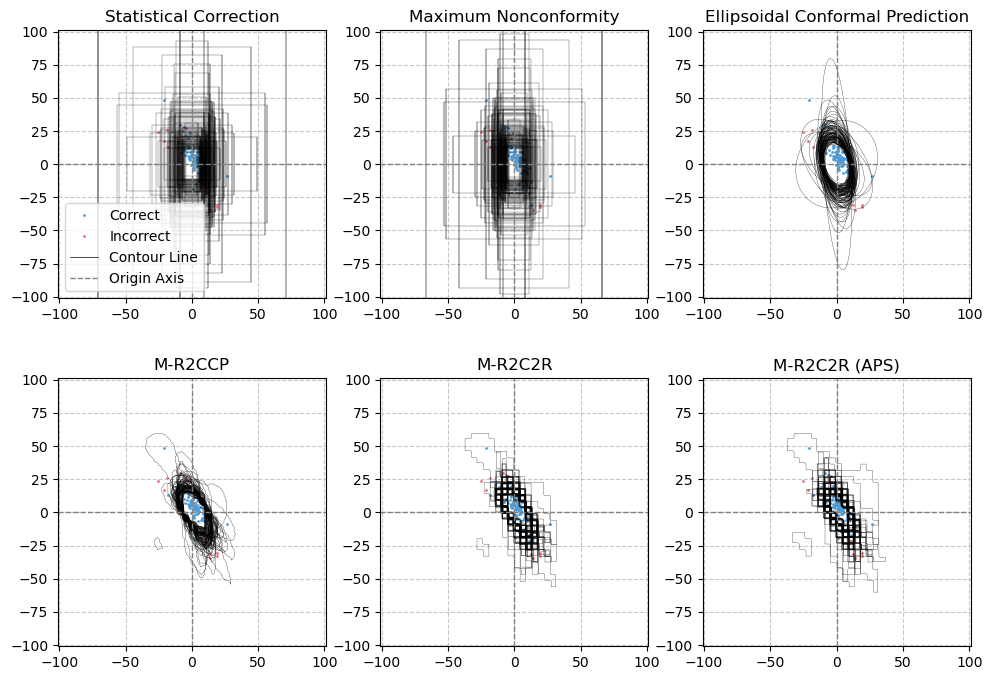

In [31]:
plot_single_landmark_all_samples(1)

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def comparison_image_pred(sample_idx, save_image=False):
    # Choose a single color for the mask
    overlay_color = np.array([75/255, 157/255, 220/255, 0.7])
    line_color = np.array([255/255, 208/255, 52/255, 1])
    true_landmark_color = "black"
    pred_landmark_color = "red"

    # Create the figure and define the GridSpec layout
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(2, 3*2, height_ratios=[1, 1], hspace=0.0, wspace=0.4)
    
    axs = [
        fig.add_subplot(gs[0, :2]),
        fig.add_subplot(gs[0, 2:4]),
        fig.add_subplot(gs[0, 4:6])
    ]
    axs.append(fig.add_subplot(gs[1, 0:2]))
    axs.append(fig.add_subplot(gs[1, 2:4]))
    axs.append(fig.add_subplot(gs[1, 4:6]))
    
    # Define titles for each subplot
    titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]
    
    
    lim_min = np.inf
    lim_max = -np.inf

    base_image = plt.imread(test_dataset.img_paths[sample_idx])
    
    # Iterate through each subplot and populate it
    for idx, ax in enumerate(axs):
        ax.set_title(titles[idx], fontsize=12)
        ax.imshow(base_image)
        
        # Select the appropriate contour and correctness data
        if idx == 2:
            pred_contour = cp_mahalanobis_one_hot_ensemble_heatmap_cov.predict_contour(
                    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                    confidence=confidence_level, sample_points=200)
        elif idx == 0:
            pred_contour = cp_bonferroni_one_hot_ensemble_heatmap_sigma.predict_contour(
                            pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            confidence=confidence_level, sample_points=200)
        elif idx == 1:
            pred_contour = cp_max_one_hot_ensemble_heatmap_sigma.predict_contour(
                            pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            confidence=confidence_level, sample_points=200)
        elif idx == 3:
            pred_contour = pred_contour_mr2ccp[sample_idx]
            pred = mr2ccp_one_hot_ensemble.predict(
                            heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            confidence=confidence_level)
        elif idx == 4:
            pred_contour = pred_contour_mr2c2r[sample_idx]
            pred = mr2c2r_one_hot_ensemble.predict(
                            heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            confidence=confidence_level)
        elif idx == 5:
            pred_contour = pred_contour_mr2c2r_aps[sample_idx]
            pred = mr2c2r_aps_one_hot_ensemble.predict(
                            heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble])[sample_idx:sample_idx+1],
                            confidence=confidence_level)

        if idx < 3:
            for i in range(test_dataset.nb_landmarks):
                contour = pred_contour[0, :, i]
                ax.fill(contour[:,1], contour[:,0], c=overlay_color)
                ax.plot(contour[:, 1], contour[:, 0], 
                                color=line_color, linewidth=0.5)
        else:
            overlay_data = pred[0].sum(axis=0)
            mask = overlay_data > 0  # Mask for non-zero values
            rgba_overlay = np.zeros((*overlay_data.shape, 4), dtype=np.float32)  # Initialize RGBA array
            rgba_overlay[..., :3] = overlay_color[:3]  # Apply RGB color to the entire array
            rgba_overlay[..., 3] = overlay_color[3] * mask  # Set alpha only where the mask is True
            ax.imshow(rgba_overlay)
            for i in range(pred.shape[1]):
                for contour in pred_contour[i]:
                    contour = np.vstack([contour, contour[0:1]])
                    ax.plot(contour[:,0,0], contour[:,0,1], c=line_color, linewidth=0.5)
        
        pred_landmarks = np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                              ).reshape((len(test_results_one_hot_ensemble), nb_landmarks, 2))[sample_idx]
        true_landmarks = test_dataset.landmarks[sample_idx]
        #ax.scatter(pred_landmarks[:,1], pred_landmarks[:,0], c=pred_landmark_color, s=1)
        ax.scatter(true_landmarks[:,1], true_landmarks[:,0], c=true_landmark_color, s=1)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        
        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])

    overlay_patch = mpatches.Patch(color=overlay_color[:3], alpha=overlay_color[3], label="Overlay Region")
    line_legend = mlines.Line2D([], [], color=line_color, linewidth=1, label="Contour Line")
    true_landmark_legend = mlines.Line2D([], [], color=true_landmark_color, marker='o', markersize=5, linestyle='None', label="True Landmark")
    #pred_landmark_legend = mlines.Line2D([], [], color=pred_landmark_color, marker='o', markersize=5, linestyle='None', label="Predicted Landmark")

    #fig.legend(handles=[overlay_patch, line_legend, true_landmark_legend, pred_landmark_legend],
    #          loc="upper center", ncol=4, fontsize=12, frameon=False)
    fig.legend(handles=[overlay_patch, line_legend, true_landmark_legend],
               loc="upper center", ncol=3, fontsize=12, frameon=False, bbox_to_anchor=(0.5, 0.92))
    plt.tight_layout()
    if save_image:
        plt.savefig(f"sample_{sample_idx}_comparison_example.pdf", bbox_inches="tight")
    plt.show()

/tmp/ipykernel_1555/3688253630.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


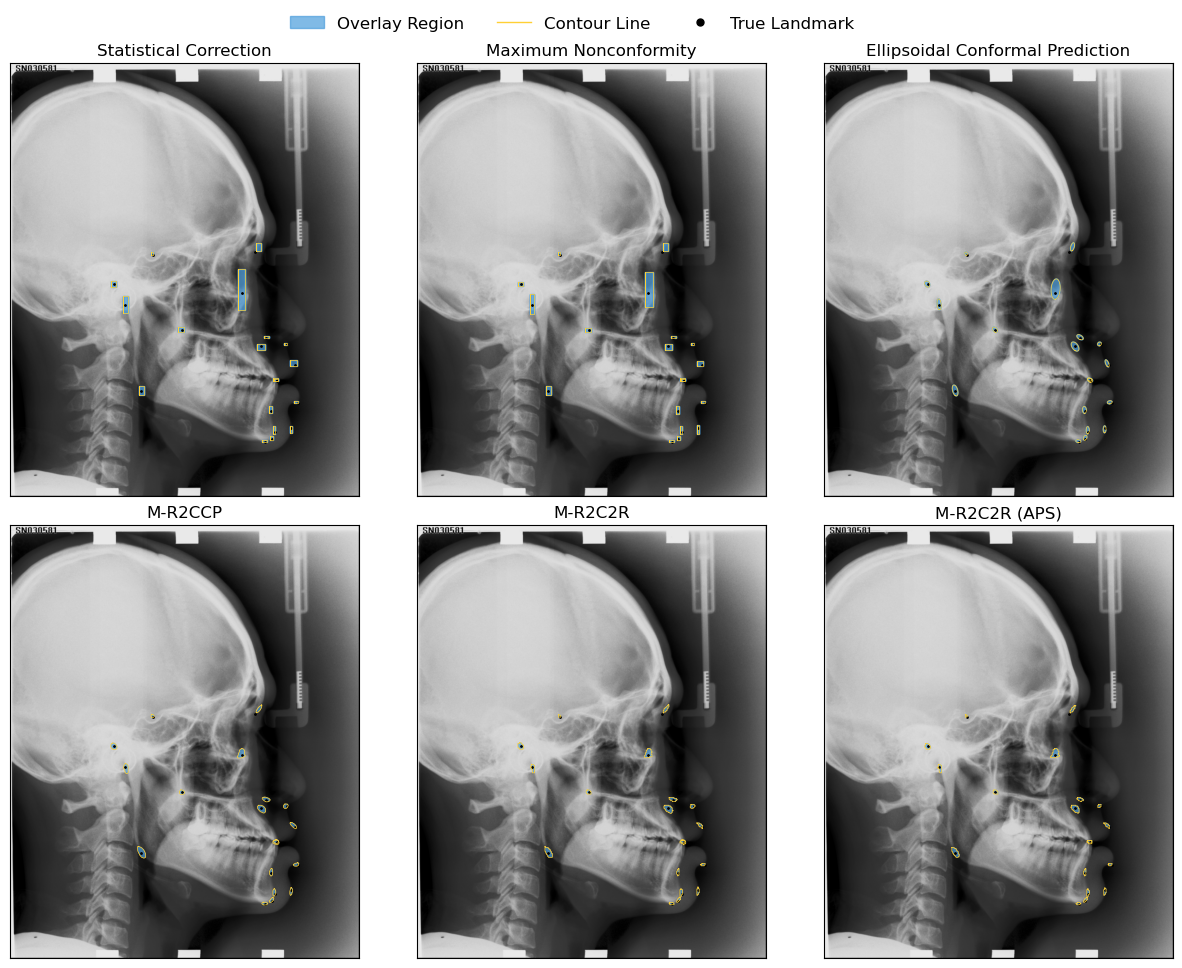

In [33]:
comparison_image_pred(72, save_image=True)

In [108]:
cp_ellipse_area = cp_mahalanobis_one_hot_ensemble_heatmap_cov.area_prediction_region(
                    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
                    spacing=test_dataset.pixel_spacings.numpy(),
                    confidence=confidence_level)

cp_bonferroni_area = cp_bonferroni_one_hot_ensemble_heatmap_sigma.area_prediction_region(
                    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
                    spacing=test_dataset.pixel_spacings.numpy(),
                    confidence=confidence_level)

cp_max_nonconformity_area = cp_bonferroni_one_hot_ensemble_heatmap_sigma.area_prediction_region(
                    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1], [0,1]] for result in test_results_one_hot_ensemble]),
                    spacing=test_dataset.pixel_spacings.numpy(),
                    confidence=confidence_level)



mr2ccp_area = mr2ccp_one_hot_ensemble.area_prediction_region(
                                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                                        spacing=test_dataset.pixel_spacings.numpy(),
                                        confidence=confidence_level
                                    )

mr2c2r_area = mr2c2r_one_hot_ensemble.area_prediction_region(
                                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                                        spacing=test_dataset.pixel_spacings.numpy(),
                                        confidence=confidence_level
                                    )

mr2c2r_aps_area = mr2c2r_aps_one_hot_ensemble.area_prediction_region(
                                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                                        spacing=test_dataset.pixel_spacings.numpy(),
                                        confidence=confidence_level
                                    )

Alert: area caluculation is a lower bound


100%|██████████| 100/100 [02:17<00:00,  1.38s/it]
